### Generic imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import math
import random
import pandas as pd
import matplotlib.image as img
import matplotlib as mpl
import numpy as np

### Create DF from dataset using images in folder

In [3]:
DATASET_TRAIN_PATH = './DataSet/train/'
DATASET_TEST_PATH = './DataSet/test/'

def create_df_from_images(ds_path):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png'):
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = img.imread(complete_fname)
            flat_image = image.flatten()
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = flat_image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            
    train['nbfinger'] = train['nbfinger'].astype('category')
    train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH)
test = create_df_from_images(DATASET_TEST_PATH)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 70.48 seconds


### Data exploration

Check repartition of images among categories - should be same for all

In [4]:
train['nbfinger'].value_counts()

5    3000
4    3000
3    3000
2    3000
1    3000
0    3000
Name: nbfinger, dtype: int64

In [5]:
train['hand'].value_counts()

R    9000
L    9000
Name: hand, dtype: int64

### Visualization

Display random image

file_name          98e29d30-1554-4f0f-b10f-9d53ebcccbb7_3L.png
image        [0.16470589, 0.16078432, 0.16078432, 0.1568627...
nbfinger                                                     3
hand                                                         L
Name: 10793, dtype: object


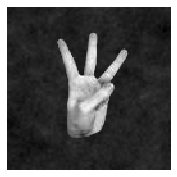

In [6]:
def plot_image(image):
    size = int(math.sqrt(len(image)))
    image_view = image.reshape(size,size)
    plt.imshow(image_view, cmap = mpl.cm.gray);
    plt.axis("off")

randidx = random.randint(0,len(train))
image = train.loc[randidx,'image']
print(train.loc[randidx,:])
plt.figure(figsize=(3,3))
plot_image(image)

Display batch images in a square matrix

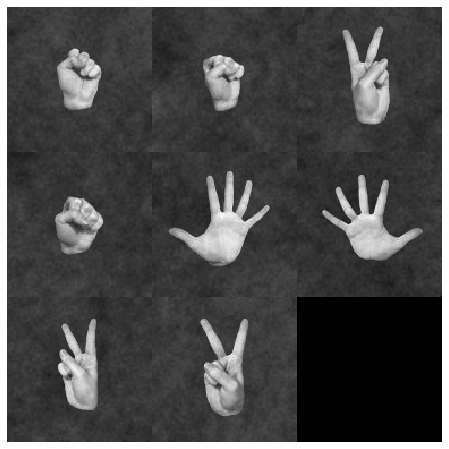

In [7]:
def plot_square_of_images(images):
    size=int(math.sqrt(len(images[0])))
    squaresize = math.ceil(math.sqrt(len(images)))
    im_row = []
    for row in range(squaresize):
        im_col=[]
        for col in range(squaresize):
            if col + squaresize * row < len(images):
                im = images[col + squaresize * row]
                im = im.reshape(size,size)
            else:
                im = np.zeros((size,size))
            im_col.append(im)
        rowofimages = np.concatenate(im_col,axis=1)
        im_row.append(rowofimages)
    squareofimages = np.concatenate(im_row,axis=0)
    flat_squareofimages = squareofimages.flatten()
    plot_image(flat_squareofimages)
    
images = train.loc[:7,'image']

plt.figure(figsize=(8,8))
plot_square_of_images(images)


### Classic classifiers

### Create train/test sets

In [8]:
xtrain = np.vstack(train['image'])
xtrain.shape

(18000, 16384)

In [10]:
from sklearn.preprocessing import LabelEncoder

ytrain = train['hand']

encoderhand = LabelEncoder()
ytrain = encoderhand.fit_transform(ytrain)

ytrain.shape

y2train = train['nbfinger']

# no need as already numericvalue
# encoderfinger = LabelEncoder()
# y2train = encoderfinger.fit_transform(y2train)

y2train.shape

(18000,)

In [11]:
xtest = np.vstack(test['image'])

In [12]:
ytest = train['hand']
ytest = encoderhand.fit_transform(ytest)
y2test = train['finger']
# y2test = encoderfinger.fit_transform(ytest)

In [13]:
# no need to scale x ??? check
# is it better to scale after PCA ?

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(xtrain)

# xtrain_s = scaler.transform(xtrain)
# xtest_s = scaler.transform(xtest)

xtrain_s = xtrain
xtest_s = xtest

### PCA to speedup classifier training (keeping 95% of variance)

In [14]:
# very long on full training dataset 18000 instances. ~13minutes !
# may need to preprocess images before
# or use another PCA method: try incremental PCA

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(xtrain_s)
t2 = time.time()
t2-t1

789.6529605388641

In [15]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 16384 to 457 after PCA preserving 95% of variance


Check how images looks like after inverse transform with PCA

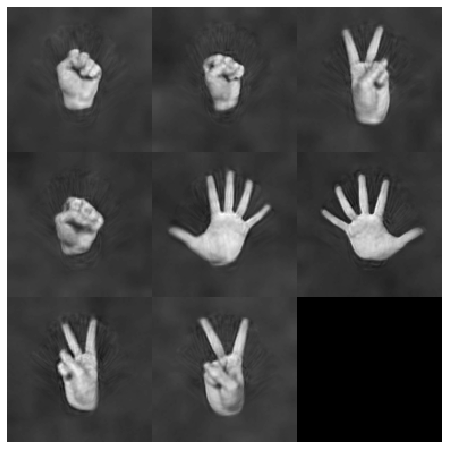

In [16]:
images = pca.inverse_transform(X_reduced[:8])

plt.figure(figsize=(8,8))
plot_square_of_images(images)

### Train some classifiers to make first evaluation

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t',
               ]

# Apply different classifiers

t0 = time.time()
for name, clf in zip(classif_names, classifs):
    t1 = time.time()
    score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    t2 = time.time()    
    print("%.2f seconds - %s Score :" % ((t2-t1),name),score)

print('classifiers trained in %.2f seconds for %d instances' %((t2 - t0),len(xtrain_s)))

#     classifier = clf.fit(xtrain_s, ytrain)
#     ypred = classifier.predict(xtest_s)
#     score1 = classifier.score(xtest_s, ytest)*100
#     score2 = accuracy_score(ypred,ytest)*100
#     print("%s Score : %.2f %% %.2f" % (name, score1,score2))


0.51 seconds - SGD		 Score : [0.999      0.99966667 1.        ]
58.62 seconds - KNN		 Score : [1. 1. 1.]
27.27 seconds - DecisionTree	 Score : [0.97683333 0.96916667 0.97633333]
31.49 seconds - SVC		 Score : [1. 1. 1.]
52.93 seconds - RandomForest	 Score : [1.         0.99983333 1.        ]
86.14 seconds - AdaBoost	 Score : [0.97716667 0.97666667 0.977     ]
classifiers trained in 256.97 seconds for 18000 instances


**--> SGD seems to bring very good results in significantly less time --> keep this one**

#### LEFT/RIGHT Hand

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, ytrain, cv=5, scoring="accuracy")

score.min()

0.9991666666666666

#### Nb of fingers

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, y2train, cv=5, scoring="accuracy")

score.min()

0.9986111111111111

### Confusion Matrix

#### LEFT/RIGHT Hand

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

ytrain_pred = cross_val_predict(clf, X_reduced, ytrain, cv=3)
confmatr = confusion_matrix(ytrain, ytrain_pred)

confmatr

array([[8997,    3],
       [   5, 8995]], dtype=int64)

Check miscategorized pictures

In [44]:
cl_R = 'R'
cl_L = 'L'

LR = X_reduced[(encoderhand.inverse_transform(ytrain) == cl_L) & (encoderhand.inverse_transform(ytrain_pred) == cl_R)]
RL = X_reduced[(encoderhand.inverse_transform(ytrain) == cl_R) & (encoderhand.inverse_transform(ytrain_pred) == cl_L)]

Left hand classifed as Right Hand


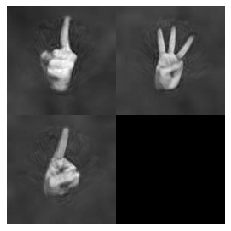

Right hand classifed as Left Hand


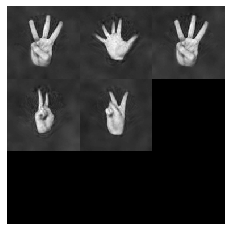

In [40]:
print('Left hand classifed as Right Hand')
plot_square_of_images(pca.inverse_transform(LR[:9]))
plt.show()
print('Right hand classifed as Left Hand')
plot_square_of_images(pca.inverse_transform(RL[:9]))
plt.show()

#### Nb of fingers

In [22]:
ytrain_pred2 = cross_val_predict(clf, X_reduced, y2train, cv=3)
confmatr2 = confusion_matrix(y2train, ytrain_pred2)

confmatr2

array([[3000,    0,    0,    0,    0,    0],
       [   0, 3000,    0,    0,    0,    0],
       [   0,    0, 3000,    0,    0,    0],
       [   0,    0,    8, 2992,    0,    0],
       [   0,    0,    0,    0, 3000,    0],
       [   0,    0,    0,    1,    0, 2999]], dtype=int64)

Check miscategorized pictures

In [56]:
cl32 = X_reduced[(y2train == 3) & (ytrain_pred2 == 2)]
cl53 = X_reduced[(y2train == 5) & (ytrain_pred2 == 3)]

3 fingers classifed as 2


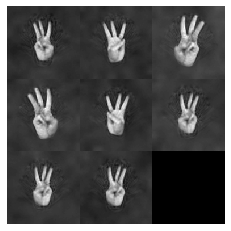

5 fingers classifed as 3


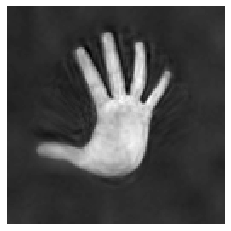

In [57]:
print('3 fingers classifed as 2')
plot_square_of_images(pca.inverse_transform(cl32[:9]))
plt.show()
print('5 fingers classifed as 3')
plot_square_of_images(pca.inverse_transform(cl53[:9]))
plt.show()